# History matching of simulation models

We demonstrate history matching of a Direct Column Breakthrough (DCB) simulation model in Mocca.
We leverage the powerful and flexible optimization functionality of Jutul to set up and perform the history matching.
For more details about the DCB modelling, see the [Simulate DCB](simulate_DCB.md) example.

First we load the necessary modules

In [1]:
import Jutul
import JutulDarcy
import Mocca

We create a function for setting up new simulation cases from the value of the parameter we wish to tune

In [2]:
function setup_case_v_feed(prm, step_info=missing)
    RealT = typeof(prm["v_feed"])
    constants = Mocca.HaghpanahConstants{RealT}(h_in = 0.0, h_out = 0.0, v_feed = prm["v_feed"])

    permeability = Mocca.compute_permeability(constants)
    axial_dispersion = Mocca.calc_dispersion(constants)

    system = Mocca.TwoComponentAdsorptionSystem(; permeability=permeability, dispersion=axial_dispersion, p=constants)

    ncells = 200
    dx = sqrt(pi * constants.r_in^2)
    mesh = Jutul.CartesianMesh((ncells, 1, 1), (constants.L, dx, dx))
    domain = Mocca.mocca_domain(mesh, system)

    model = Jutul.SimulationModel(domain, system, general_ad=true)

    bar = Jutul.si_unit(:bar)
    P_init = 1 * bar
    T_init = 298.15
    Tw_init = constants.T_a

    yCO2 = fill(1e-10, ncells)
    y_init = hcat(yCO2, 1 .- yCO2)

    state0, parameters = Mocca.initialise_state_AdsorptionColumn(P_init, T_init, Tw_init, y_init, model)

    t_ads = 5000
    maxdt = 5000.0
    numsteps = Int(floor(t_ads / maxdt))
    timesteps = fill(maxdt, numsteps)

    bc = Mocca.AdsorptionBC(y_feed=constants.y_feed, PH=constants.p_high, v_feed=constants.v_feed,
        T_feed=constants.T_feed, cell_left=1, cell_right=ncells)

    sim_forces = Jutul.setup_forces(model, bc=bc)

    return Jutul.JutulCase(model, timesteps, sim_forces; state0 = state0, parameters = parameters)
end;

# Create synthetic reference data

In [3]:
constants_ref = Mocca.HaghpanahConstants{Float64}(h_in=0.0, h_out=0.0)
prm_ref = Dict("v_feed" => constants_ref.v_feed)
case_ref = setup_case_v_feed(prm_ref)

t_c = Jutul.VariableChangeTimestepSelector(:y, 0.01, relative = false)
t_t = Jutul.VariableChangeTimestepSelector(:Temperature, 10.0, relative = false)
t_p = Jutul.VariableChangeTimestepSelector(:Pressure, 10.0, relative = false);
t_base = Jutul.TimestepSelector(initial_absolute = 1.0)
timesteppers = [t_base, t_c, t_t, t_p];

sim = Jutul.Simulator(case_ref)
lsolve = Jutul.LUSolver()

cfg = Jutul.simulator_config(sim;
    timestep_selectors = timesteppers,
    output_substates = true,
    linear_solver = lsolve,
    info_level = -1
);

result = Jutul.simulate(case_ref;
    config = cfg
);

Extract the substates and subtimesteps used inside the simulator

In [4]:
substates, subtimesteps = Jutul.expand_to_ministeps(result);

We create an interpolation function to be able to sample the reference solution at arbitrary points in time

In [5]:
times_ref = cumsum(subtimesteps)
total_time = times_ref[end]
last_cell_idx = Jutul.number_of_cells(case_ref.model.domain)
qCO2_ref = map(s -> getindex(s[:AdsorbedConcentration], 1, last_cell_idx), substates)
qCO2_ref_by_time = Jutul.get_1d_interpolator(times_ref, qCO2_ref);

# Setting up and solving the optimization problem
We define a suitable objective function to quantify the match between our simulations and the reference solution.
Here we choose deviation of adsorbed CO2 in the last grid cell.

In [6]:
function objective_function(model, state, dt, step_info, forces)
    current_time = step_info[:time] + dt
    q_co2 = getindex(state[:AdsorbedConcentration], 1, last_cell_idx)
    q_co2_ref = qCO2_ref_by_time(current_time)
    v = dt/total_time*(q_co2 - q_co2_ref)^2
    return v
end;

Perturb the known parameter $v_{feed}$ to form our initial guess for the optimization

In [7]:
prm_guess = Dict("v_feed" => constants_ref.v_feed+0.2)

Dict{String, Float64} with 1 entry:
  "v_feed" => 0.57

Activate $v_{feed}$ as a free parameter and run the optimization

In [8]:
dprm = Jutul.DictOptimization.DictParameters(prm_guess)
Jutul.DictOptimization.free_optimization_parameter!(dprm, "v_feed"; rel_min = 0.1, rel_max = 10.0)
prm_opt = Jutul.DictOptimization.optimize(dprm, objective_function, setup_case_v_feed;
    config = cfg,
    max_it = 10,
);

Optimization: Starting calibration of 1 parameters.
Optimization: Setting up adjoint storage.
Optimization: Finished setup in 2.274145292 seconds.
It.  | Objective  | Proj. grad | Linesearch-its
-----------------------------------------------
   0 | 7.5689e+05 | 2.6607e+07 | -
LBFGS: Hessian not updated during iteration 1
   1 | 8.0173e+03 | 2.6607e+07 | 2
LBFGS: Resetting 'm' to number of parameters: m = 1
   2 | 4.7507e+01 | 7.3105e+06 | 2
   3 | 1.5732e+00 | 5.4987e+05 | 1
   4 | 1.7658e-02 | 1.0880e+05 | 1
   5 | 2.4549e-06 | 1.1492e+04 | 1
   6 | 6.2521e-10 | 1.3597e+02 | 1
   7 | 2.9845e-12 | 2.1603e+00 | 1
Optimization: Finished in 21.2930415 seconds.


We can see a clear reduction of the objective function value throughout the optimization iterations,
indicating a close match between the reference solution and our simulation.

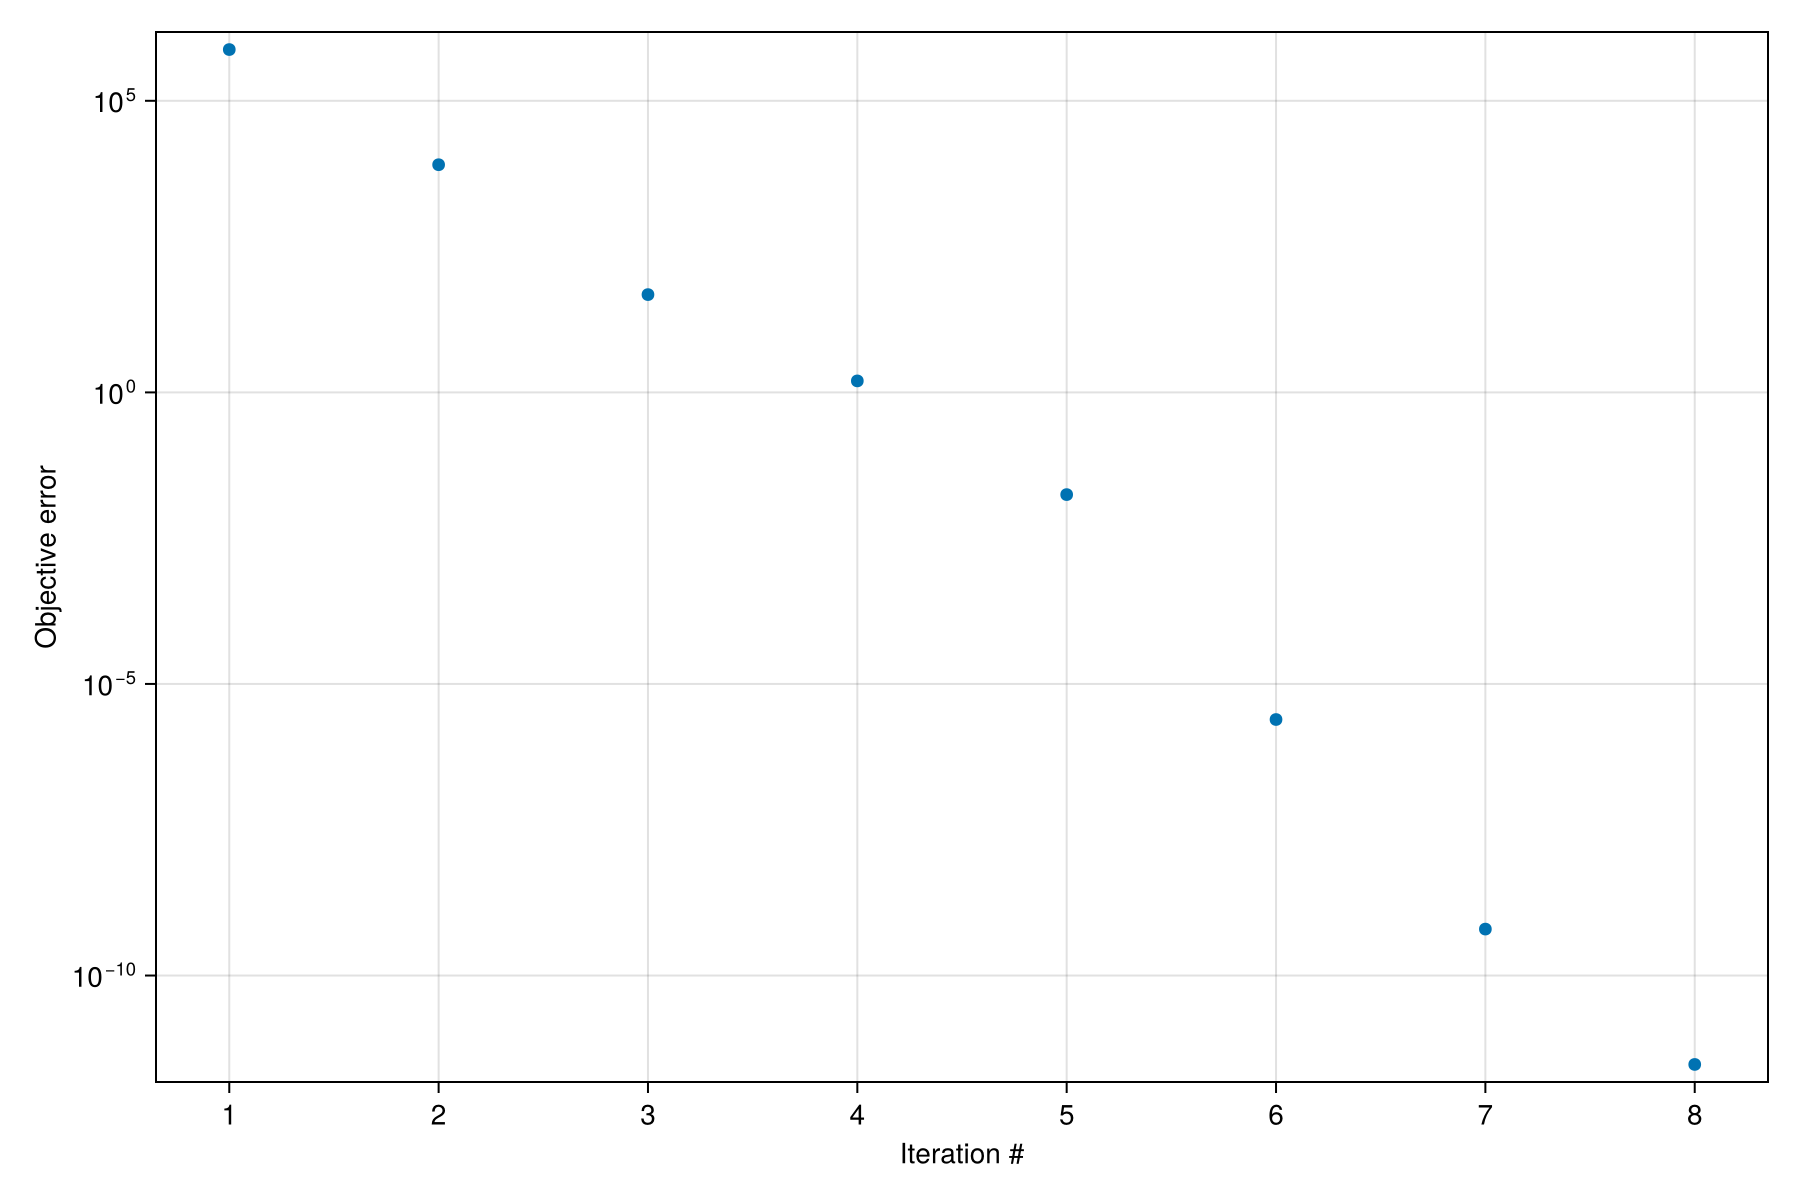

In [9]:
f = Mocca.plot_optimization_history(dprm)

We can look at the optimization result:

In [10]:
dprm

DictParameters with 1 active parameters and 0 inactive:
Active optimization parameters
┌────────┬───────────────┬───────┬───────┬─────┬─────────────────┬────────┐
│   Name │ Initial value │ Count │   Min │ Max │ Optimized value │ Change │
├────────┼───────────────┼───────┼───────┼─────┼─────────────────┼────────┤
│ v_feed │ 0.57          │     1 │ 0.057 │ 5.7 │ 0.37            │ -35.0% │
└────────┴───────────────┴───────┴───────┴─────┴─────────────────┴────────┘
No inactive optimization parameters.


and see that the value matches the reference parameter value

In [11]:
constants_ref.v_feed

0.37

## Example on GitHub
If you would like to run this example yourself, it can be downloaded from [the Mocca.jl GitHub repository](https://github.com/sintefmath/Mocca.jl/blob/main/examples/history_matching.jl).

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*